In [1]:
import numpy as np
import os
import nibabel as nib
import skimage
import matplotlib.pyplot as plt

In [3]:
t2 = nib.load('./T2w.nii.gz').get_fdata()

## BG mask extraction from tool-based tissue mask

In [5]:
# infantFS or dHCP pipeline mask
# if dHCP pipeline mask
aseg = nib.load('./label_87.nii.gz').get_fdata()

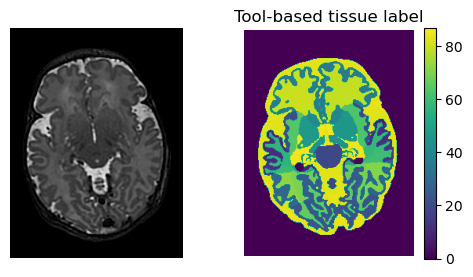

In [41]:
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.imshow(np.rot90(t2[:, :, 130]), 'gray');plt.axis('off')
plt.subplot(122)
plt.imshow(np.rot90(aseg[:, :, 130]));plt.axis('off')
plt.title('Tool-based tissue label')
plt.colorbar()
plt.show()

In [34]:
bg = np.zeros_like(aseg)
bg[aseg ==46]=1
bg[aseg ==47]=1
bg[aseg ==40]=1
bg[aseg ==41]=1

dilated_bg = skimage.morphology.binary_dilation(bg, skimage.morphology.ball(3))

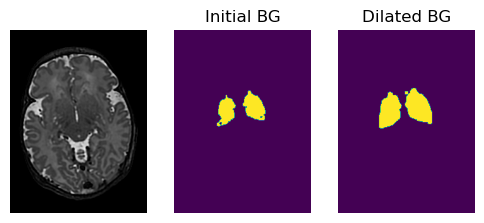

In [40]:
plt.figure(figsize=(6, 3))
plt.subplot(131)
plt.imshow(np.rot90(t2[:, :, 130]), 'gray');plt.axis('off')
plt.subplot(132)
plt.imshow(np.rot90(bg[:, :, 130]));plt.axis('off')
plt.title('Initial BG')
plt.subplot(133)
plt.imshow(np.rot90(dilated_bg[:, :, 130]));plt.axis('off')
plt.title('Dilated BG')
plt.show()

## Generate Frangi-filtered PVS

In [66]:
from skimage.filters import frangi, hessian

pvsd = frangi(t2,sigmas=(.5, .7), scale_step=1, black_ridges=False)  

In [67]:
t = pvsd[pvsd!=0]
pvs_th = np.percentile(t, 90)
pvsd[dilated_bg==0]=0
init_pvs = (pvsd>pvs_th).astype(np.int8)

In [68]:
dilated_pvs = skimage.morphology.binary_dilation(init_pvs, skimage.morphology.ball(3))

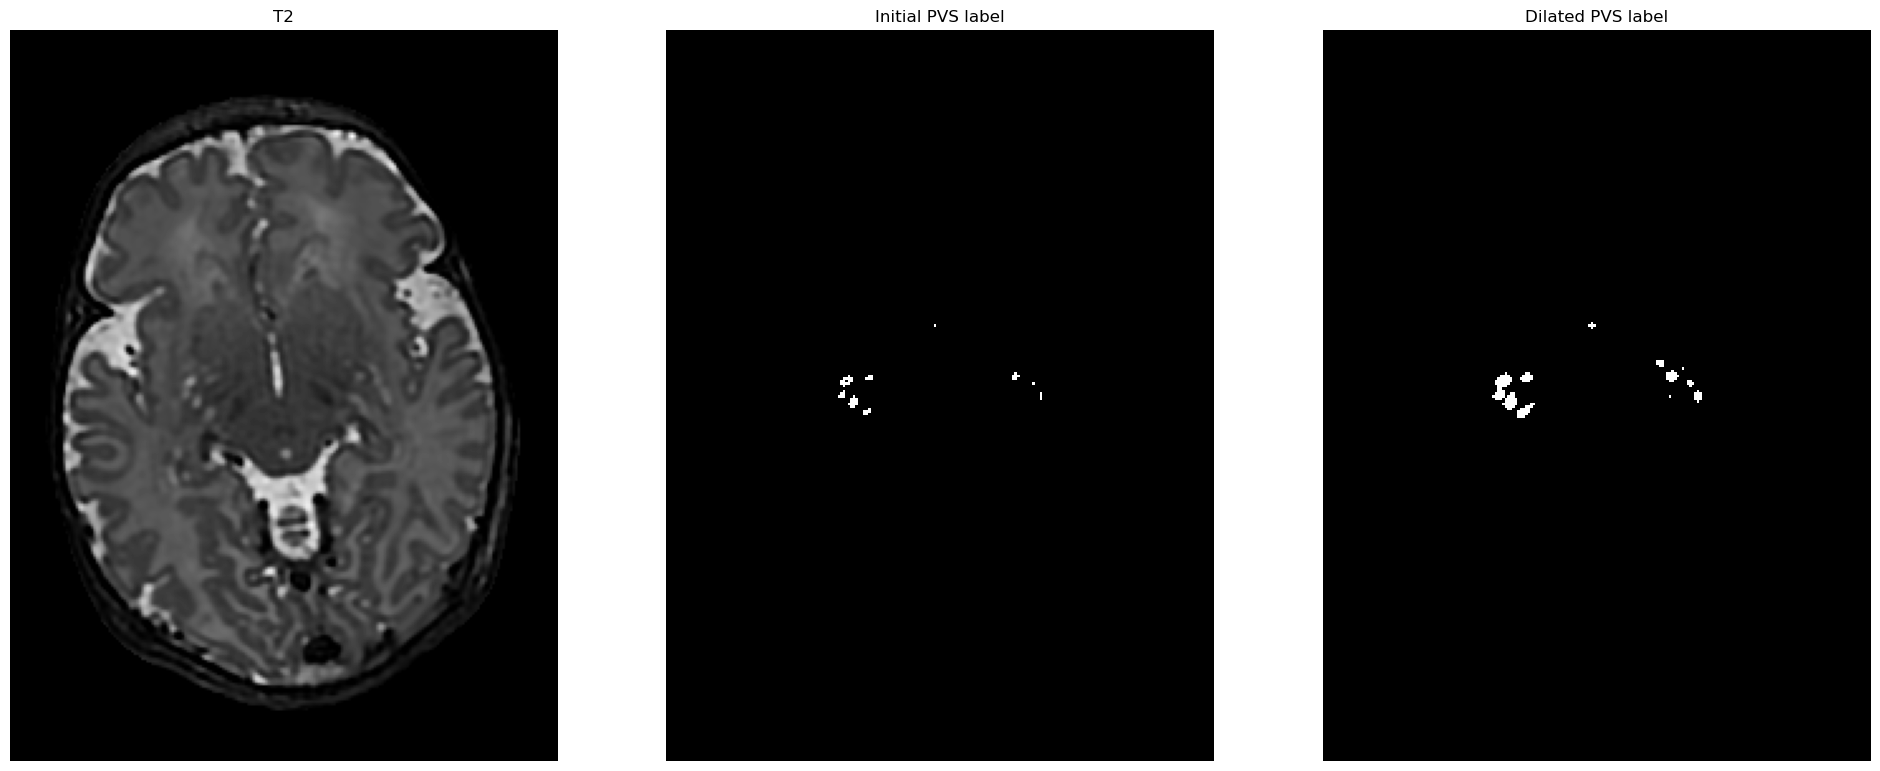

In [69]:
n=130
plt.figure(figsize=(24,18))
plt.subplot(131)
plt.imshow(np.rot90(t2[:,:,n]),cmap='gray')
plt.title('T2')
plt.axis('off')
plt.subplot(132)
plt.imshow(np.rot90(pvsd[:,:,n]>pvs_th),cmap='gray',interpolation='nearest')
plt.axis('off')
plt.title('Initial PVS label')
plt.subplot(133)
plt.imshow(np.rot90(dilated_pvs[:,:,n]),cmap='gray',interpolation='nearest')
plt.axis('off')
plt.title('Dilated PVS label')
plt.show()

## BG refinement step with dilated PVS

In [70]:
L, N = skimage.measure.label(dilated_pvs, return_num=True)
new = np.zeros(dilated_pvs.shape)
for num in range(1, N+1):
    label1 = (L==num).astype('int')
    overlap_label = np.logical_and(label1, bg).astype(int)

In [71]:
refine_bg = bg+new
refine_bg = (refine_bg>0).astype('int')
new = np.zeros(refine_bg.shape)
new[:, :, i] = skimage.morphology.binary_closing(refine_bg[:, :, i], skimage.morphology.ball(1))


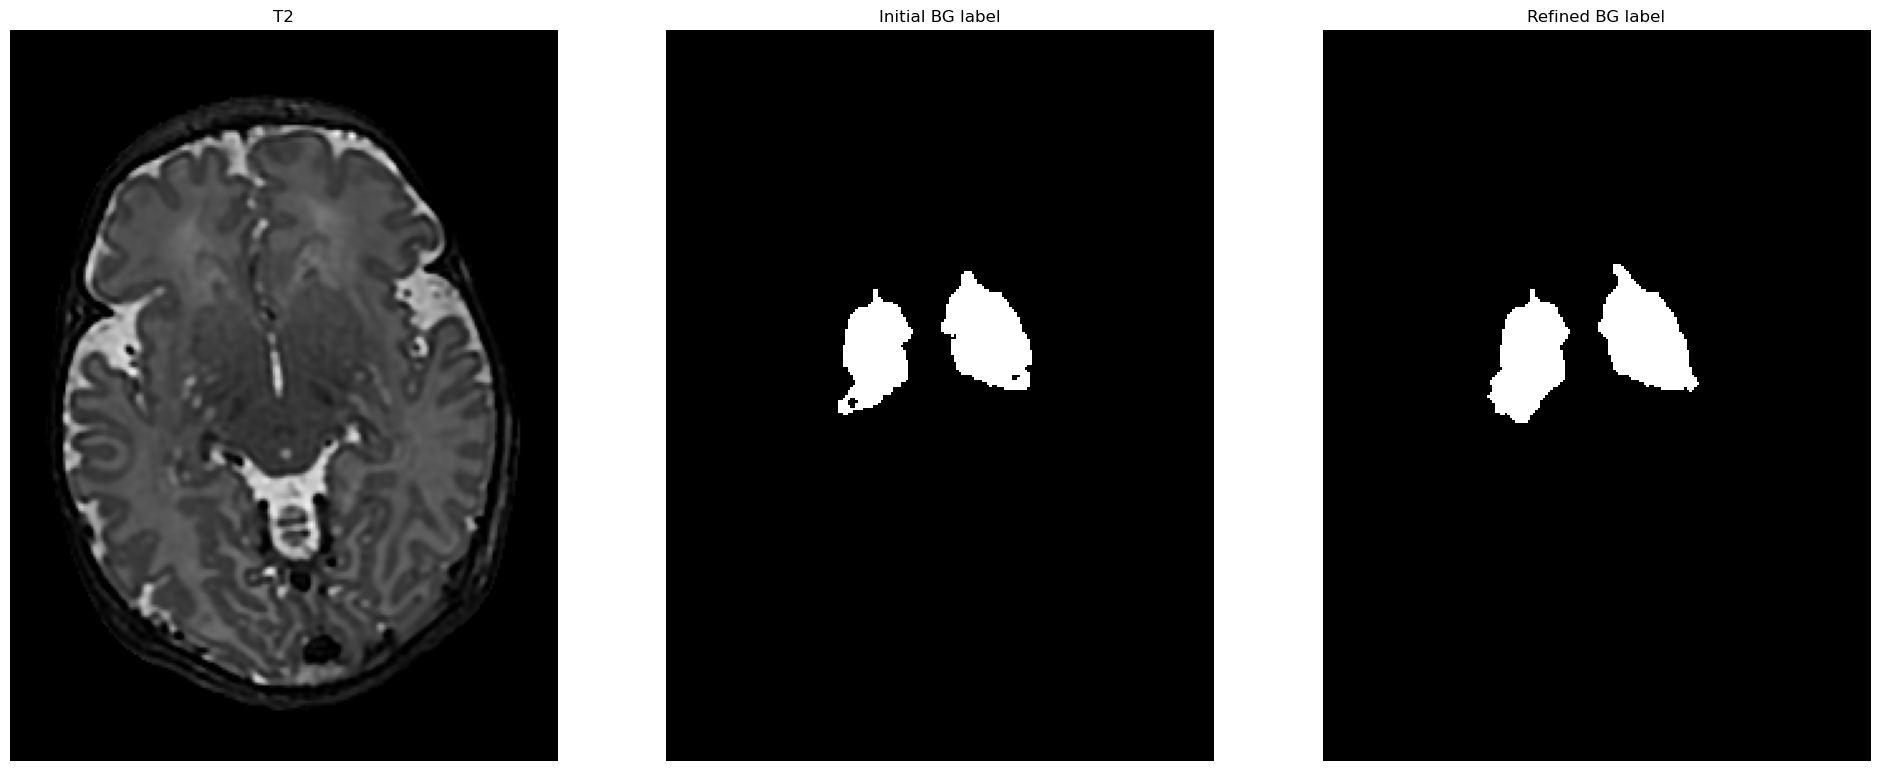

In [72]:
n=130
pvs_th = 0.25
plt.figure(figsize=(24,18))
plt.subplot(131)
plt.imshow(np.rot90(t2[:,:,n]),cmap='gray')
plt.title('T2')
plt.axis('off')
plt.subplot(132)
plt.imshow(np.rot90(bg[:,:,n]>pvs_th),cmap='gray',interpolation='nearest')
plt.axis('off')
plt.title('Initial BG label')
plt.subplot(133)
plt.imshow(np.rot90(new[:,:,n]),cmap='gray',interpolation='nearest')
plt.axis('off')
plt.title('Refined BG label')
plt.show()